In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.datasets import load_digits, make_blobs, load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    silhouette_score,
    silhouette_samples
)

from scipy.cluster.hierarchy import dendrogram

In [2]:
plt.style.use("ggplot")

### **Clustering**

In [3]:
# Ejercicio 2

In [4]:
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [5]:
X = digits.data
y = digits.target

In [6]:
(n_samples, n_features), n_digits = X.shape, np.unique(y).size
print(f"# digits: {n_digits}; # samples: {n_samples}; # features: {n_features}")

# digits: 10; # samples: 1797; # features: 64


In [7]:
def benchmark_KMeans(kmeans, name, data, labels):
    """
    Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """

    t0 = time.time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    tf = time.time()

    fit_time = tf - t0

    results = [name, fit_time, estimator[-1].inertia_]

    clustering_metrics = [
        homogeneity_score,
        completeness_score,
        v_measure_score,
        adjusted_rand_score,
        adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    results += [
        silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

In [8]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(
    n_clusters=n_digits,
    init="k-means++",
    n_init=4,
    random_state=42,
    algorithm="lloyd"
)
benchmark_KMeans(kmeans, "k-means++", X, y)

kmeans = KMeans(
    n_clusters=n_digits, 
    init="random", 
    n_init=4, 
    random_state=42,
    algorithm="lloyd"
)
benchmark_KMeans(kmeans, "random", X, y)

pca = PCA(n_components=n_digits).fit(X)
kmeans = KMeans(
    n_clusters=n_digits,
    init=pca.components_, 
    n_init=1,
    algorithm="lloyd"
)
benchmark_KMeans(kmeans, "PCA-based", X, y)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.223s	4660	0.741	0.763	0.752	0.655	0.749	0.174
random   	0.126s	4647	0.738	0.746	0.742	0.671	0.739	0.189
PCA-based	0.018s	4827	0.722	0.730	0.726	0.641	0.723	0.150
__________________________________________________________________________________


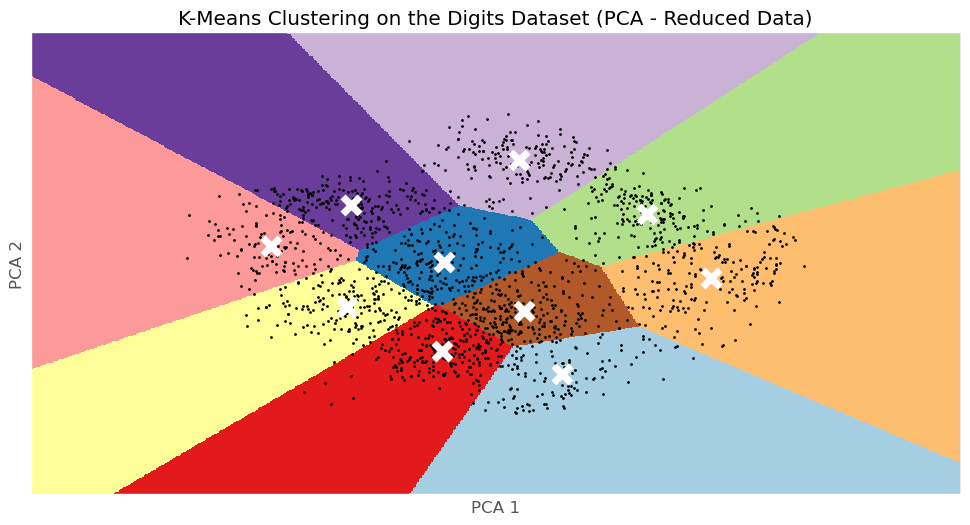

In [9]:
reduced_data = make_pipeline(
    MinMaxScaler(),
    PCA(n_components=2),
).fit_transform(X)

kmeans = KMeans(
    n_clusters=n_digits,
    init="k-means++",
    n_init=4,
    random_state=42,
    algorithm="lloyd"
)
kmeans.fit(reduced_data)

centroids = kmeans.cluster_centers_

x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(12, 6))

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)

plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=150,
    linewidths=5,
    color="w",
    zorder=10,
)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.title("K-Means Clustering on the Digits Dataset (PCA - Reduced Data)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.xticks(())
plt.yticks(())

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.show()

In [10]:
# Ejercicio 3

silhouette_score: 0.7050 (n_clusters = 2)
silhouette_score: 0.5882 (n_clusters = 3)
silhouette_score: 0.6505 (n_clusters = 4)
silhouette_score: 0.5615 (n_clusters = 5)
silhouette_score: 0.4525 (n_clusters = 6)


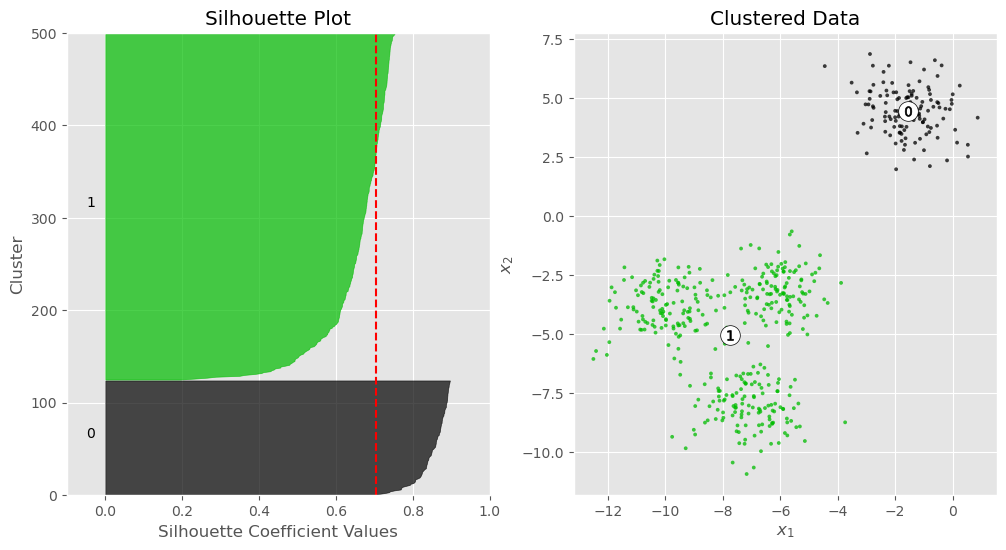

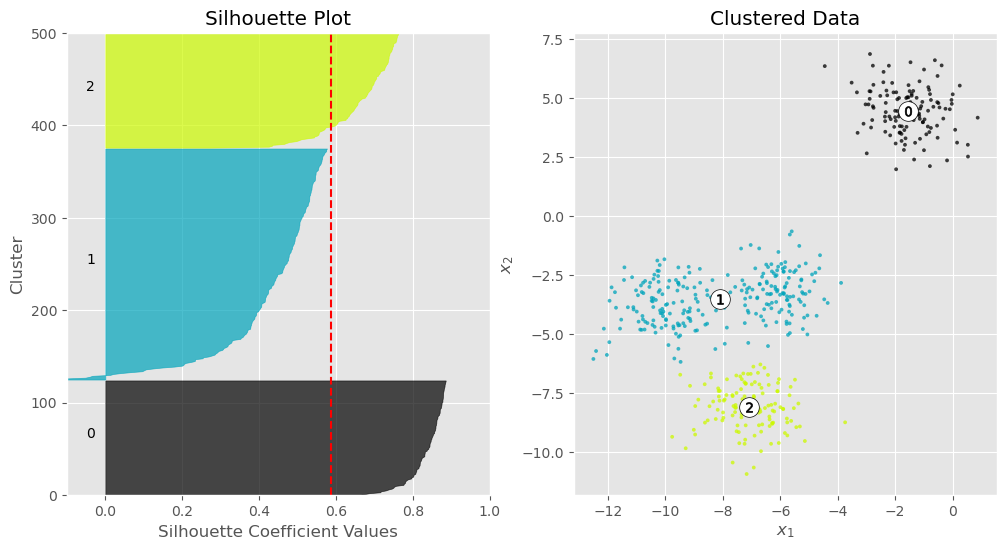

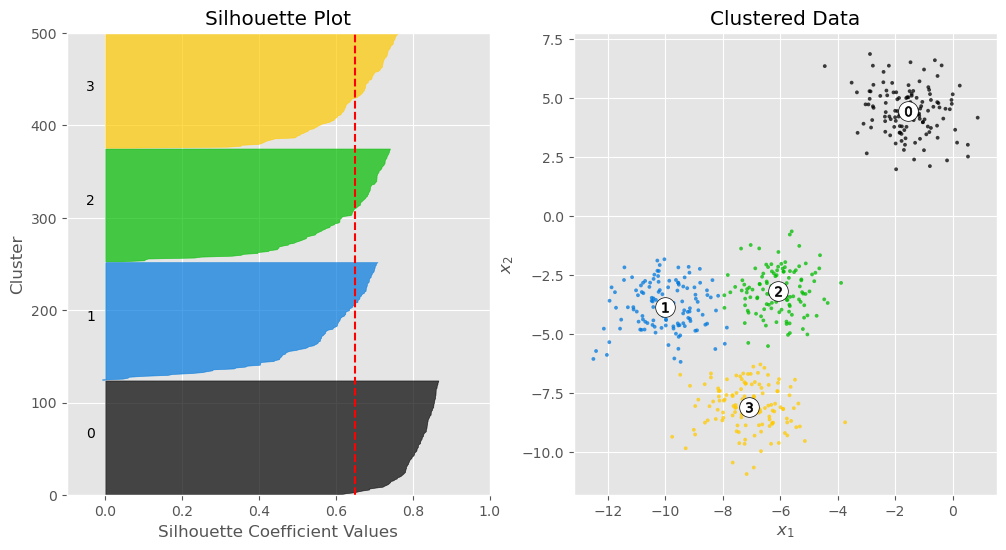

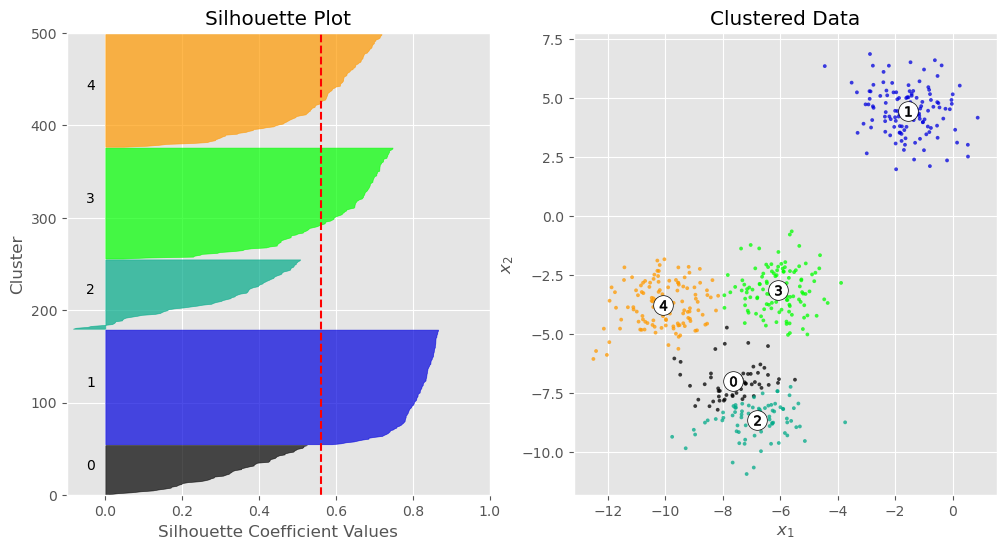

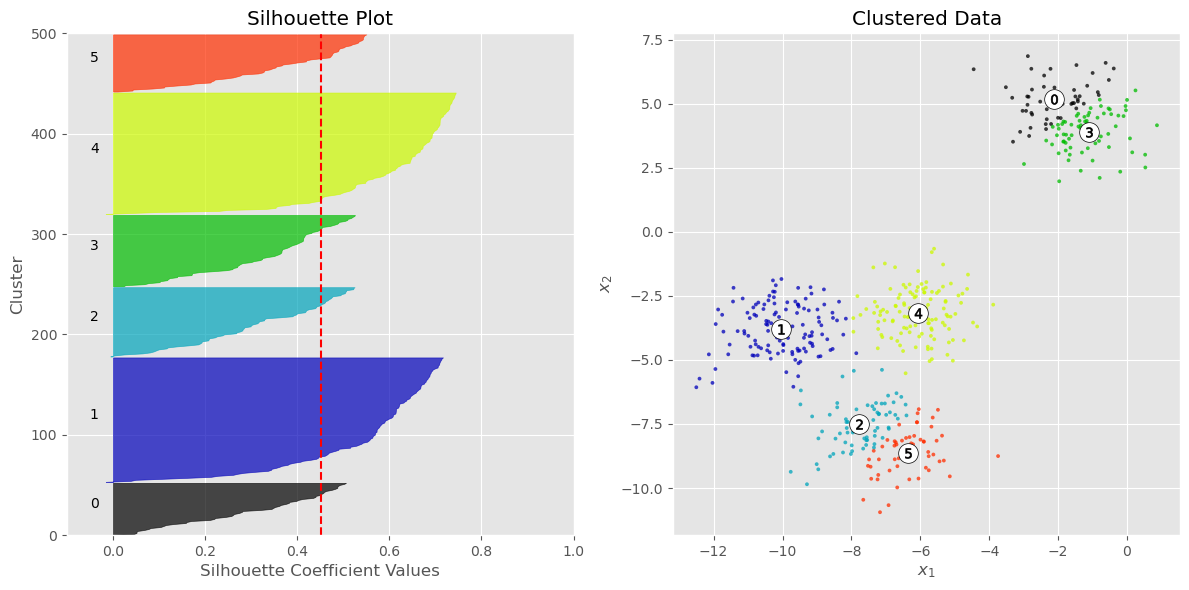

In [11]:
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)

for n_clusters in [2, 3, 4, 5, 6]:

    kmeans = KMeans(
        n_clusters, 
        init="k-means++", 
        n_init=4, 
        random_state=42
    )
    kmeans.fit(X)

    cluster_labels = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    print(
        f"silhouette_score: {silhouette_avg:.4f} "
        f"(n_clusters = {n_clusters})"
    )
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    ax[0].set_xlim([-0.1, 1])
    ax[0].set_ylim([0, len(X)])
    y_lower = 0
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax[0].fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)
        ax[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper
    ax[0].axvline(x=silhouette_avg, color="red", linestyle="--")
    ax[0].set_title("Silhouette Plot")
    ax[0].set_xlabel("Silhouette Coefficient Values")
    ax[0].set_ylabel("Cluster")

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax[1].scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.75, c=colors, edgecolor='k')
    centers = kmeans.cluster_centers_
    ax[1].scatter(centers[:, 0], centers[:, 1], marker='o',
                  c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax[1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                      s=50, c='black')
    ax[1].set_title("Clustered Data")
    ax[1].set_xlabel(r"$x_1$")
    ax[1].set_ylabel(r"$x_2$")

plt.tight_layout()

plt.show()

In [12]:
# Ejercicio 4

In [13]:
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [14]:
X = digits.data
y = digits.target

In [15]:
(n_samples, n_features), n_digits = X.shape, np.unique(y).size
print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [16]:
def plot_clustering(X_2d, labels, title):

    x_min, x_max = np.min(X_2d, axis=0), np.max(X_2d, axis=0)
    X_2d = (X_2d - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))

    for digit in digits.target_names:
        plt.scatter(
            *X_2d[y == digit].T,
            marker=f"${digit}$",
            s=50,
            color=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.25,
        )

    plt.title(title, size=16)

    plt.xticks(())
    plt.yticks(())

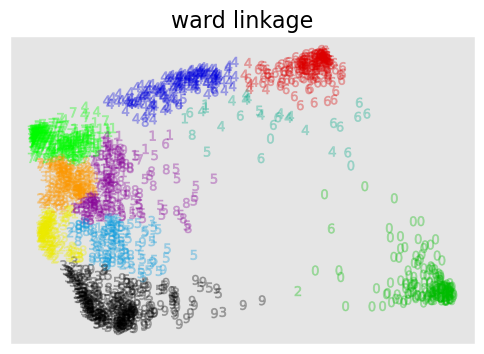

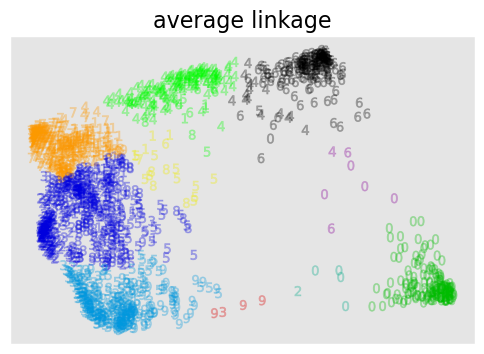

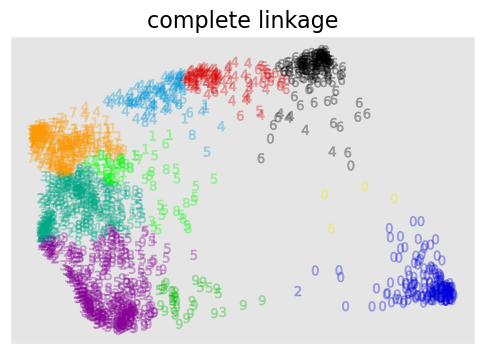

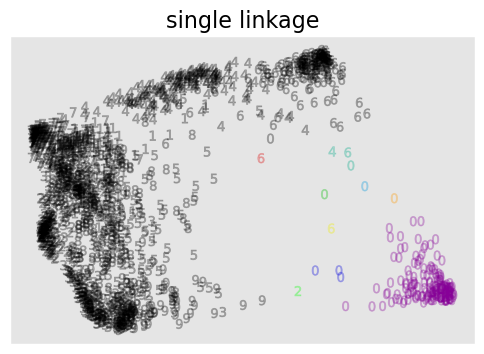

In [17]:
embedding = SpectralEmbedding(n_components=2)
X_2d = embedding.fit_transform(X)

for linkage in ("ward", "average", "complete", "single"):

    clustering = AgglomerativeClustering(
        n_clusters=n_digits,
        linkage=linkage
    )
    clustering.fit(X_2d)

    plot_clustering(X_2d, clustering.labels_, title=f"{linkage} linkage")

plt.show()

In [18]:
# Ejercicio 5

In [19]:
iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [20]:
X = iris.data
y = iris.target

In [21]:
def plot_dendrogram(clustering, **kwargs):

    n_samples = len(clustering.labels_)
    counts = np.zeros(clustering.children_.shape[0])
    
    for i, merge in enumerate(clustering.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [clustering.children_, clustering.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

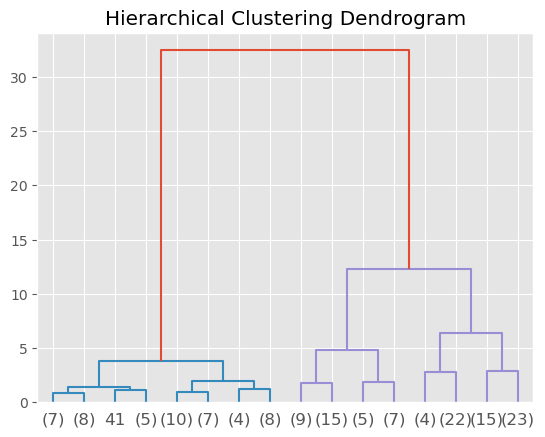

In [22]:
clustering = AgglomerativeClustering(
    n_clusters=None,
    linkage="ward",
    distance_threshold=0
)
clustering.fit(X)

plot_dendrogram(clustering, truncate_mode="level", p=3)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()